In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import noror

from ivp_integrator import ivp_integrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
trajectories = noror.utils.load_trajectories(filename='../trajectories_n_kmax=200.npz')
derivs = noror.utils.load_trajectories(filename='../derivs_n_kmax=200.npz')


ind = 1

trajectories = trajectories[::ind]
derivs = derivs[::ind]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_trajectories = trajectories[:cutoff]
train_derivs = derivs[:cutoff]

test_trajectories = trajectories[cutoff:]
test_derivs = derivs[cutoff:]


1000 loaded with n_kmax = 200


In [59]:
dim_reducer = noror.dim_reducers.SVD()
scaler = noror.scalers.standardize_scaler(1.0)
transformer = noror.transformers.ELM_features(ELM_nodes=1000)
optimizer = noror.optimizers.ridge(alpha=10.**-0)

model = noror.noror(train_trajectories, train_derivs, rdim=15, VAR_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  15
VAR_l:  2
train shape:  (360000, 1031)
target shape:  (360000, 200)
weights shape:  (1031, 200)


In [60]:
integrator = ivp_integrator(model, dt=1.0, dt_out=5., method='Euler')

NF error: 0.011991191231892549
max error: 0.04023465575636011


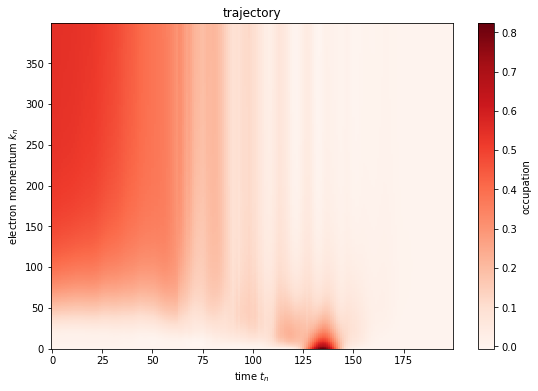

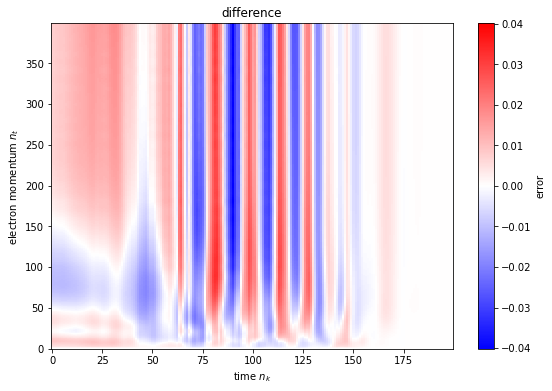

In [61]:
test_trajectory = test_trajectories[1]


pred = integrator.integrate(test_trajectory,test_trajectory.shape[0])


print('NF error:', integrator.get_error(test_trajectory,pred, norm='NF'))
print('max error:', integrator.get_error(test_trajectory,pred, norm='max'))


noror.utils.plot_trajectory(pred)

noror.utils.plot_difference(truth=test_trajectory,test=pred)


In [62]:
mean, mscores = integrator.score_multiple_trajectories(test_trajectories, norm='NF')
print(mean)

0.007469874601612457


0.007469874601612457


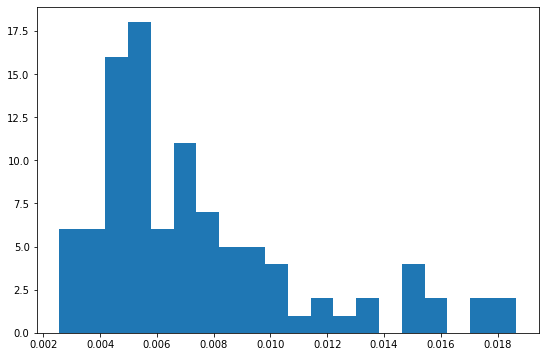

In [63]:
print(mean)

plt.hist(mscores,bins=20)
plt.show()

In [74]:
dim_reducer = noror.dim_reducers.SVD()
scaler = noror.scalers.standardize_scaler(1.0)
transformer = noror.transformers.ELM_features(ELM_nodes=1000)
optimizer = noror.optimizers.ridge(alpha=10.**2)

model = noror.noror(rdim=15, VAR_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)


integrator = ivp_integrator(model, dt=1.0, dt_out=5., method='Euler')


scores = noror.utils.get_KFold_CV_scores(integrator, trajectories, derivs, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs={})

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  0.00551099314202435 +- 0.004378325168844436
max error:  0.020858399374648364 +- 0.018150623729815206


NF error:  0.00551099314202435 +- 0.004378325168844436
max error:  0.020858399374648364 +- 0.018150623729815206


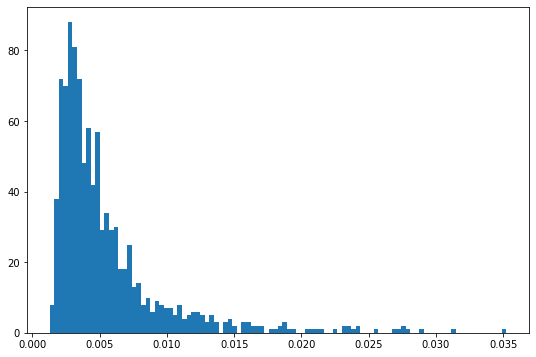

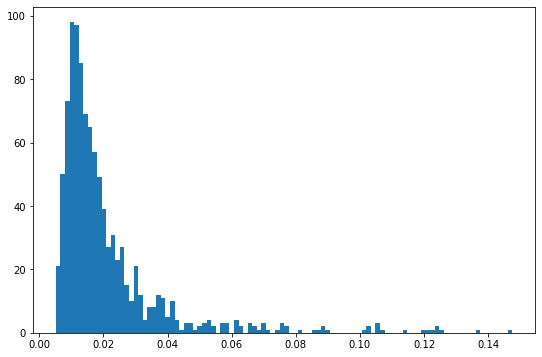

In [75]:
print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

plt.hist(scores[0],bins=100)
plt.show()

plt.hist(scores[1],bins=100)
plt.show()